In [1]:

# ****************************************************************************
#                       DATA ORGANIZATION and FORMATING
# ****************************************************************************

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import nan

# ------ LOAD data-tables ---------------------------------------------------- 
# List of clinical table with features and timepoints
# => ClinicalData_Klinisk.csv ------------ Patients list and clinical data  (sheets "Klinik fra Randi")
#                                        - (including medications, treatments etc...)
# => ClinicalData_Oversikt.csv ----------- Sample list of all timepoint measurements (sheet "Oversikt")
#                                        - (in theory 5 each patient)
# => Lipoproteinene_Combined2.csv -------- Lipoprotein measurements (blood serum)
# => Metabolittene_comb_final_clean.csv -- Metabolomics measurments (blood serum)

path_Klinisk  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Klinisk.csv" 
path_Oversikt = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Oversikt.csv" 
path_Lipopro  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Lipoproteinene_Combined2.csv" 
path_Metabol  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Metabolittene_comb_final_clean.csv" 

root_path = os.path.dirname(path_Lipopro)
             
# Load clinical data files, Lipoprotein and Metabolites measurments files 
# NOTE: There are some redundant columns!
CD_klinisk = pd.read_csv( path_Klinisk,  header=1, index_col=False)
CD_oversik = pd.read_csv( path_Oversikt, header=0, index_col=False)
LP_measure = pd.read_csv( path_Lipopro,  header=0, index_col=False)
MB_measure = pd.read_csv( path_Metabol,  header=0, index_col=False)


# ------ PRUNING the data ----------------------------------------------------
# Extract the timepoints as defined by Guro. We could also redifine by looking 
# dates or use dates to find matching measurments between different dataframes 
sele_oversik  = [ "PatientID", 
                  "Samplenames lipo", "Names date modified", "Samling date", 
                  "Dato stråleterapi", 
                  "Timepoint", "Timepoint_kodet",
                  "Alder", "BMI", 
                  "HEr2 ", "ER ", "PGR","kjemo", "herceptin" , "hormornbeh",
                  "FatPAS.1", "FatPAS.2", "FatPAS.3", "FatPAS.4", "FatPAS.5"]
CD_samples  = CD_oversik.loc[:,sele_oversik]

# Simplify the names of the Metabolites dataframe columns, removing the unit
names = MB_measure.columns
MB_measure.columns = [xx.split(" (RawConc)")[0] for xx in names]

# Rename column e.g. "Samplenames lipo" in CD_oversik === "name" in LP_measure
CD_samples = CD_samples.rename(columns={"Samplenames lipo": "Samplename"})
LP_measure = LP_measure.rename(columns={"name": "Samplename"})
MB_measure = MB_measure.rename(columns={"Sample Name": "Samplename"})
CD_samples = CD_samples.rename(columns={"HEr2 ": "HER2"})
CD_samples = CD_samples.rename(columns={"ER ": "ER"})

# Insert a "PatientID" column in LP and MB dataframes (redundant but good practice)
pID = [ xx.split("_")[0] for xx in LP_measure["Samplename"]]
LP_measure.insert( loc=1, column="PatientID", value=pID)
pID = [ xx.split("_")[0] for xx in MB_measure["Samplename"]]
MB_measure.insert( loc=1, column="PatientID", value=pID)


# ! Ensure that the different DFs (CD, LP and MB) have the exact same set of 
#   samples in their list. Use "Samplename" compare and remove those samples
#   that appear only in one dataframe.
# NOTE: check manually on the list what we are actually removing !!!
#       Specifically, LP have less samples than MP and CD
# Use set-difference to find missing samples in LP_measure, then reomve those
# from the list. Finally, subset DFs selecting only common samples
miss_nn = np.setdiff1d( CD_samples["Samplename"], LP_measure["Samplename"])
list_nn = np.setdiff1d( CD_samples["Samplename"], miss_nn )
CD_samples = CD_samples.loc[CD_samples["Samplename"].isin(list_nn)]

# As above, but between LP_measure and MB_measure
# NOTE: MB_measure has repeated measurments for a couple of samples !!!
miss_nn = np.setdiff1d( MB_measure["Samplename"], LP_measure["Samplename"])
list_nn = np.setdiff1d( MB_measure["Samplename"], miss_nn )
MB_measure = MB_measure.loc[MB_measure["Samplename"].isin(list_nn)]

# Remove quality control measurments: strings starting with "QC"
mask_QC = ["QC" not in xx   for xx in LP_measure["Samplename"]]
CD_samples = CD_samples.loc[ mask_QC, : ]
LP_measure = LP_measure.loc[ mask_QC, : ]
MB_measure = MB_measure.loc[ mask_QC, : ]


# At this point we have the exact same entries in both DataFrames. 
# (Check by running np.setdiff1d in all combinations between the 3 DFs)
# Sort-by name columns "Samplename" and then remove uncategorized timepoints.
CD_samples = CD_samples.sort_values("Samplename")
LP_measure = LP_measure.sort_values("Samplename")
MB_measure = MB_measure.sort_values("Samplename")


# --- Selection by HER2 analysis
# Correct Syntax errors in Time column ('pre ' (with space) instead of 'pre')
idx = CD_samples.index[CD_samples['Timepoint']== 'pre '].tolist()
CD_samples.loc[idx] = CD_samples.loc[idx]['Timepoint'] = 'pre'

# Remove the samples tagged "pre" in HER2 column
#mask = np.array(CD_samples["PGR"] == -100)
# Remove 'nan' values (CD_samples['Timepoint']== '?')
mask = CD_samples["Timepoint_kodet"].isnull().values
CD_samples = CD_samples.loc[ ~mask, : ]
LP_measure = LP_measure.loc[ ~mask, : ]
MB_measure = MB_measure.loc[ ~mask, : ]



# ------ REORGANIZE and SORT variables ---------------------------------------
# Now all DFs the sample measurements sorted in the same order (Samplename)
# Thus, we reindex the rows in all DFs to be the same.
CD_samples = CD_samples.reset_index(drop=True)
LP_measure = LP_measure.reset_index(drop=True)
MB_measure = MB_measure.reset_index(drop=True)

# Reorganize the "covariates" order so that we remove redundant (colinear) 
# factors and we can plot them together based on meaningful grouping
# and order (e.g. class of molecules)
# TG  = tryglyceride
# CH  = total cholesterol
# FC  = free cholesterol
# (EC = esterified cholesterol) 
# PL  = phosppholipids
# AB  = ApoB  (=== particle numbers, for specific class)
# A1  = ApoA (only HDL)
vars_LP_order = [  
                'V1TG', 'V1CH', 'V1FC', 'V1PL', 
                'V2TG', 'V2CH', 'V2FC', 'V2PL', 
                'V3TG', 'V3CH', 'V3FC', 'V3PL', 
                'V4TG', 'V4CH', 'V4FC', 'V4PL', 
                'V5TG', 'V5CH', 'V5FC', 'V5PL', 

                'IDTG', 'IDCH', 'IDFC', 'IDPL',

                'L1TG', 'L1CH', 'L1FC', 'L1PL',
                'L2TG', 'L2CH', 'L2FC', 'L2PL',
                'L3TG', 'L3CH', 'L3FC', 'L3PL',
                'L4TG', 'L4CH', 'L4FC', 'L4PL',
                'L5TG', 'L5CH', 'L5FC', 'L5PL',
                'L6TG', 'L6CH', 'L6FC', 'L6PL',

                'H1TG', 'H1CH', 'H1FC', 'H1PL', 'H1A1', 'H1A2',
                'H2TG', 'H2CH', 'H2FC', 'H2PL', 'H2A1', 'H2A2',
                'H3TG', 'H3CH', 'H3FC', 'H3PL', 'H3A1', 'H3A2',
                'H4TG', 'H4CH', 'H4FC', 'H4PL', 'H4A1', 'H4A2',
                ]
vars_MB_order = [ 'Lysine', 'Histidine', 'Glutamic acid',
                  'Glutamine', 'Asparagine', 'Threonine', 
                  'Glycine', 'Proline',
                  'Phenylalanine', 'Leucine', 'Alanine', 'Tyrosine', 'Valine', 'Isoleucine', 'Methionine',                  
                  'N,N-Dimethylglycine', 'Ornithine', 'Sarcosine',                 
                  '2-Hydroxybutyric acid', '3-Hydroxybutyric acid', '2-Oxoglutaric acid', '2-Aminobutyric acid',
                  'Pyruvic acid', 'Citric acid', 'Acetic acid', 'Lactic acid', 'Succinic acid', 'Formic acid', 'Acetoacetic acid',                  
                  'K-EDTA','Ca-EDTA',                 
                  'Acetone', 'Glycerol',                 
                  'D-Galactose', 'Glucose',                 
                  'Dimethylsulfone',                   
                  'Choline', 'Creatine', 'Creatinine'
                 ]

data = LP_measure.iloc[:,4:]
# Simplify the index (covariates) names by removing the "unit"
names = data.columns.values
names = [ xx.split(" [")[0] for xx in names]
data.columns = names
# select and sort on ly the variables in vars_LP_order
data = data.loc[:,vars_LP_order] 
data = data.reindex(vars_LP_order, axis = 1)
LP_measure = pd.concat( [LP_measure.iloc[:,0:4], data], axis = 1 )

data = MB_measure.iloc[:,2:]
data = data.reindex(vars_MB_order, axis = 1)
MB_measure = pd.concat( [MB_measure.iloc[:,0:2], data], axis = 1 )



# ------ SAVE ----------------------------------------------------------------
# Save as Python-Ready .csv file
CD_samples.to_csv( root_path + "/PyR_Sample_ClinikData.csv"  , header=True, index=True)
LP_measure.to_csv( root_path + "/PyR_Lipoproteine.csv", header=True, index=True)
MB_measure.to_csv( root_path + "/PyR_Metabolittene.csv", header=True, index=True)




# ------ LOAD SURVIVAL data-tables -------------------------------------------
# List of patients and importantly the survival. We need to load as .xlsx 
# because there are comment columns with "commas" that alter the table when 
# uploaded as .csv file
# Survival state:  1= lever,  2= tilbakefall, 3= kreftdød,     4= annen død 
#                  1= alive,  2= relapse,     3= cancer death, 4= other death 

path_Survival = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Radiationstudy_survival_modified_MS.xlsx" 
CD_survival = pd.read_excel( path_Survival,  header=0, index_col=False )

# we do not take columns: 
# 6 - Komorbidity - a description and requires manual conversion to some categorical data type
sele_survival = [ 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12]
name_conversion = {"PID":             "PatientID",
                   "Dato start RT":   "Date_StartRadio",
                   "10-års-kontroll lege/siste livstegn": "Date_10yCheck",
                   "QOL-skjema":           "Date_QOLquestionnaire",
                   "Kun QOL":              "With_QOL",
                   "Antall dettatt":       "N_Participant",
                   "Metastase/ ny kreft":  "NewCancer",
                   "Dato mors":            "Date_Death",
                   "Dato tilbakefall":     "Date_Relapse",
                   "Oppfølgingstid":       "Followup",
                   "Status, 1= lever, 2 = tilbakefall, 3 = kreftdød, 4 = annen død":   "Status"
                  }

CD_survival = CD_survival.iloc[:, sele_survival]
CD_survival = CD_survival.rename(columns= name_conversion)

# Uniformize the date from strings to datetime64 
# NOTE: NAN strings (possibly no follow up due to death) are convered into
#       NaT in datetime64. To find NaT use .isnull() method
CD_survival["Date_StartRadio"] = pd.to_datetime(CD_survival["Date_StartRadio"], infer_datetime_format=True, errors='coerce')
CD_survival["Date_10yCheck"]   = pd.to_datetime(CD_survival["Date_10yCheck"], infer_datetime_format=True, errors='coerce')
CD_survival["Date_Death"]      = pd.to_datetime(CD_survival["Date_Death"], infer_datetime_format=True, errors='coerce')
CD_survival["Date_Relapse"]    = pd.to_datetime(CD_survival["Date_Relapse"], infer_datetime_format=True, errors='coerce')
CD_survival["Date_QOLquestionnaire"] = pd.to_datetime(CD_survival["Date_QOLquestionnaire"], infer_datetime_format=True, errors='coerce')

# Replace NaN and convert scolumns into simple 0-1 values
mask    = CD_survival["N_Participant"].isnull()
CD_survival.loc[mask, "N_Participant"] = 0
mask    = CD_survival["N_Participant"].isnull()
CD_survival.loc[mask, "N_Participant"] = 0
mask    = CD_survival["NewCancer"].isnull()
CD_survival.loc[mask, "NewCancer"] = 0

# Simplify survival state in binary: 0 deaths of any type; 1 for alive
mask_1 = CD_survival["Status"] == 1

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
mask_2 = CD_survival["Status"] >= 2
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


CD_survival.loc[mask_1, "Status_code"] = 1
CD_survival.loc[mask_2, "Status_code"] = 0
#mask = CD_survival.loc[:, "Status_code"].isnull() 


# ------ SAVE ----------------------------------------------------------------
# Save as Python-Ready .csv file
CD_survival.to_csv( root_path + "/PyR_Patients_Survival.csv" , header=True, index=True)




# ------ COMBINE ----------------------------------------------------------------
# Add information on survival in the sample information DF: CD_samples
# Initialize "0" column and then, for all alive PatientID replace with "1"
CD_samples.insert( loc=8, column="Status_code", value=0)
mask = CD_survival.loc[:, "Status_code"] == 1
pIDList = CD_survival.loc[mask, "PatientID"].values
for ii_patient in pIDList: 
    CD_samples.loc[ CD_samples.loc[:,"PatientID"] == str(ii_patient) , "Status_code" ] = 1

print("pID_Survive:  ", (CD_survival.loc[:, "Status_code"] == 1).sum() )
print("pID_Dead   :  ", (CD_survival.loc[:, "Status_code"] == 0).sum() )
print("Smp_Survive:  ", (CD_samples.loc[:, "Status_code"] == 1).sum() )
print("Smp_Dead   :  ", (CD_samples.loc[:, "Status_code"] == 0).sum() )

pID_Survive:   201
pID_Dead   :   49
Smp_Survive:   798
Smp_Dead   :   191


In [1452]:
import scipy.stats as st
import sys
# Add as desired to the list of known working paths for Python 
sys.path.append('/Users/mattesa/ZenBook/Python/PLS-DA')

import mbc_PLS_basic
from mbc_PLS_basic import *
# Force reload during development, otherwise Python only loads first time 
# and does not update unless the kernel is rebooted
import importlib
importlib.reload(mbc_PLS_basic)


# --- 0 --- Parameters for the cross validation ------------------------------
# Column name for the response variable to use in PLS-DA
unique_PID   = "PatientID"
Response_Col = "hormornbeh"
timepoint    = 5

fold_save    = "Survival"
data_type    = "LP"

outer_PropSele = 0.20     # proportion train-to-test to use
inner_PropSele = 0.20    
outer_loop = 40           # cycles number to perform double cross val.
inner_loop = 10
max_N_comp = 10           # Maximum number of components to test
min_cat    = 0
max_cat    = 1

# Transform categories into 0 and 1 response values
transform_cat = True
if transform_cat == True :
    min_rval = 0
    max_rval = 1
    p_threshold = 0.5                       # predicted probability threshold
else:
    min_rval = min_cat
    max_rval = max_cat
    p_threshold = (min_cat+max_cat) / 2     # predicted probability threshold



             

# --- 1 --- Prepare the DataFrames in the appropriate format -----------------
# Prepare the data we wish to use for the PLS model in XX and YY dataframes.
YY = CD_samples.copy()
# Chose the dataset according to the data_type
if   data_type == "LP":
    dataset = LP_measure               
elif data_type == "MB":
    dataset = MB_measure 
elif data_type == "LP-MB":
    dataset = pd.concat([LP_measure, MB_measure.iloc[:,2:]], axis = 1)
    
# Select only samples from a specific time point
mask = YY["Timepoint_kodet"]== 5
YY = YY.loc[mask]
dataset = dataset.loc[mask]

# Remove samples with NaN values in Response_Col
mask = YY[Response_Col].isnull().values
YY = YY.loc[ ~mask, : ]
dataset = dataset.loc[ ~mask, : ]



# Display how many sample there are for each category.
col_name = "Status_code"
data_column = YY[Response_Col]
categ = [min_cat, max_cat]
for cc in categ:
    tot = ( data_column == cc).sum()
    print(cc, " - ",  tot)

# Scale-standardize the XX matrix and reduce selection only for data with 
# specific values in "Response_Col" column (min_cat, max_cat)
XX_vars_scaled, XX_scaled = StandardScale_FeatureTable( dataset , 4)
XX, YY = CrossSelect_TwoTables( XX_vars_scaled, YY, Response_Col, [min_cat,max_cat], transform_cat ) 


0  -  64
1  -  83


Iteration:   : 40 of 40

Mode num. LV:  2.0
Accuracy    :  0.67  ( 0.641, 0.689 )


,Mean
Accuracy,0.665000
Specificity,0.551923
Sensitivity,0.751471
Best_nLV,3.750000


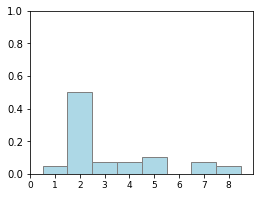

In [1157]:
# --- 2 --- Cross-validation of PLS ------------------------------------------
# Outer
#   Inner
#     number LV
PerfoMetric, comparPred, outerCAL, totalCAL, optimal_nLV = optimise_PLS_CrossVal(
                        XX, YY, max_N_comp, unique_PID,
                        Response_Col, min_rval, max_rval, p_threshold , 
                        outer_loop, inner_loop, outer_PropSele, inner_PropSele,
                        True)
# Calculate the Accuracy CI (confidence intervals)
data  = PerfoMetric.loc["Accuracy"].values.tolist()
CI = st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))
CI = [ CI[xx] for xx in range(len(CI))]      # tuple-to-list conversion

# Visuallize key results on accuracy and optimal LV number
print("\n")
print("Mode num. LV:  " + str(optimal_nLV) )
PerfoMetric["Mean"] = PerfoMetric.mean(axis=1)
print("Accuracy    :  " + str(round( PerfoMetric.mean(axis=1)["Accuracy"], 2))
                        + "  ( " +str(round(CI[0],4))+", "+str(round(CI[1],4))+ " )" ) 

pd.DataFrame( PerfoMetric["Mean"] )

# plot_metrics(outerMSE.iloc[ 0:1, :].T.values, 'MSE', 'min')

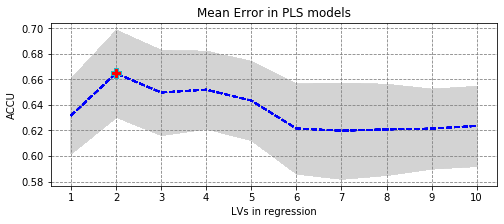

In [1162]:
plot_metrics( outerCAL.T.values , 'ACCU', 'max', True)

In [1492]:
## ************************************************************
#                          O-PLS
# ************************************************************

from pyopls import *
# Create the class OPLS, with the LV to orthogonalize into the first component 
# that was found from perfoming PLS cross validation
opls = OPLS(2)                # opt_nLV
# Fit the model to the data, then get the non-orthogonal components of X 
# i.e. Learn and apply filtering on the training data and get the filtered X, 
# which is called variable Z in the code
Z  = opls.fit_transform( XX, YY[Response_Col])
ZZ_opls = pd.DataFrame(data = Z, columns = XX.columns.values, index = XX.index.values)

X_scores_ortho_PrePLS = pd.DataFrame(data = opls.T_ortho_ , 
                              columns = ["oScores_V_"+str(xx+1) for xx in range(opls.T_ortho_.shape[1])], 
                              index = ZZ.index.values)

X_loads_ortho_PrePLS  = pd.DataFrame(data = opls.P_ortho_ , 
                              columns = ["oLoads_LV_"+str(xx+1) for xx in range(opls.P_ortho_.shape[1])], 
                              index = ZZ.columns.values)

# --->  Now data is orthogonalized, we can plot scores and loadings

# Build PLS predicion model using orthoganalized dataset Z (for comparison to oPLS) 
# pls = PLSRegression(2)
# ZZ_pls = pls.fit(Z, M_Y)

# opls.T_ortho_.shape
# pls.x_scores_.shape
# opls.P_ortho_.shape
# pls.x_loadings_.shape

X_scores_PLS, _, _, _ = PLS_fit_model( XX, YY.loc[:, Response_Col], 6, Response_Col)
X_scores_ortho_PostPLS, _, _, _ = PLS_fit_model( ZZ, YY.loc[:, Response_Col], 6, Response_Col)
"""
NLV = 3
opls = OPLS(NLV)
Z  = opls.fit_transform( XX, YY[Response_Col])
ZZ = pd.DataFrame(data = Z, columns = XX.columns.values, index = XX.index.values)
X_scores_ortho_PrePLS = pd.DataFrame(data = opls.T_ortho_ , 
                              columns = ["oScores_V_"+str(xx+1) for xx in range(opls.T_ortho_.shape[1])], 
                              index = ZZ.index.values)
X_scores_PLS, _, _, _ = PLS_fit_model( XX, YY.loc[:, Response_Col], NLV, Response_Col)
X_scores_ortho_PostPLS, _, _, _ = PLS_fit_model( ZZ, YY.loc[:, Response_Col], NLV, Response_Col)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
plot_ScoresPLS( X_scores_PLS, YY, Response_Col, [min_cat,max_cat], ax1 )
plot_ScoresPLS( X_scores_ortho_PrePLS, YY, Response_Col, [min_cat,max_cat], ax2 )
plot_ScoresPLS( X_scores_ortho_PostPLS, YY, Response_Col, [min_cat,max_cat] , ax3)
"""

'\nNLV = 3\nopls = OPLS(NLV)\nZ  = opls.fit_transform( XX, YY[Response_Col])\nZZ = pd.DataFrame(data = Z, columns = XX.columns.values, index = XX.index.values)\nX_scores_ortho_PrePLS = pd.DataFrame(data = opls.T_ortho_ , \n                              columns = ["oScores_V_"+str(xx+1) for xx in range(opls.T_ortho_.shape[1])], \n                              index = ZZ.index.values)\nX_scores_PLS, _, _, _ = PLS_fit_model( XX, YY.loc[:, Response_Col], NLV, Response_Col)\nX_scores_ortho_PostPLS, _, _, _ = PLS_fit_model( ZZ, YY.loc[:, Response_Col], NLV, Response_Col)\n\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))\nplot_ScoresPLS( X_scores_PLS, YY, Response_Col, [min_cat,max_cat], ax1 )\nplot_ScoresPLS( X_scores_ortho_PrePLS, YY, Response_Col, [min_cat,max_cat], ax2 )\nplot_ScoresPLS( X_scores_ortho_PostPLS, YY, Response_Col, [min_cat,max_cat] , ax3)\n'

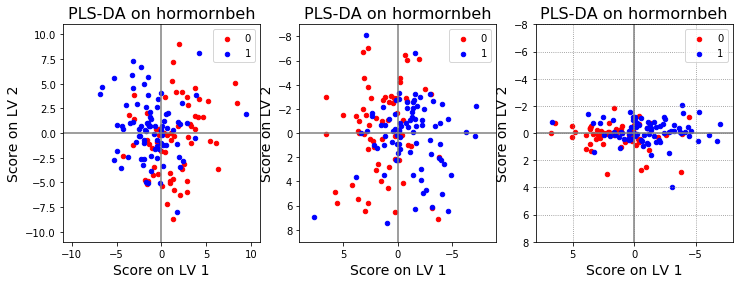

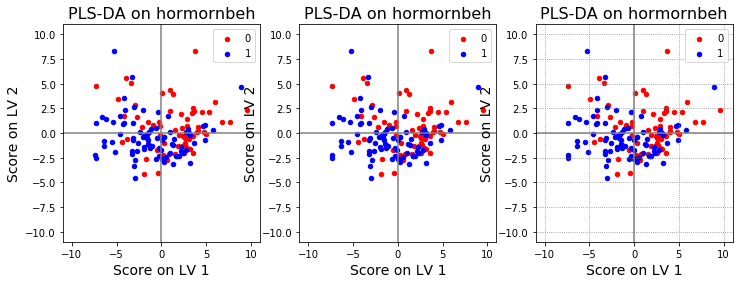

In [1507]:
# --- 3 --- Final PLS model --------------------------------------------------
NLV = 1
opls = OPLS(NLV)
Z  = opls.fit_transform( XX, YY[Response_Col])
ZZ = pd.DataFrame(data = Z, columns = XX.columns.values, index = XX.index.values)
X_scores_oPLS1, _, _, _ = PLS_fit_model( ZZ, YY.loc[:, Response_Col], 6, Response_Col)

# --- 3 --- Final PLS model --------------------------------------------------
NLV = 2
opls = OPLS(NLV)
Z  = opls.fit_transform( XX, YY[Response_Col])
ZZ = pd.DataFrame(data = Z, columns = XX.columns.values, index = XX.index.values)
X_scores_oPLS2, _, _, _ = PLS_fit_model( ZZ, YY.loc[:, Response_Col], 6, Response_Col)

# --- 3 --- Final PLS model --------------------------------------------------
NLV = 3
opls = OPLS(NLV)
Z  = opls.fit_transform( XX, YY[Response_Col])
ZZ = pd.DataFrame(data = Z, columns = XX.columns.values, index = XX.index.values)
X_scores_oPLS3, _, _, _ = PLS_fit_model( ZZ, YY.loc[:, Response_Col], 6, Response_Col)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
plot_ScoresPLS( X_scores_oPLS1, YY, Response_Col, [min_cat,max_cat] , ax1)
plot_ScoresPLS( X_scores_oPLS2, YY, Response_Col, [min_cat,max_cat] , ax2)
plot_ScoresPLS( X_scores_oPLS3, YY, Response_Col, [min_cat,max_cat] , ax3)




X_scores_PLS1, _, _, _ = PLS_fit_model( XX, YY.loc[:, Response_Col], 2, Response_Col)
X_scores_PLS2, _, _, _ = PLS_fit_model( XX, YY.loc[:, Response_Col], 4, Response_Col)
X_scores_PLS3, _, _, _ = PLS_fit_model( XX, YY.loc[:, Response_Col], 6, Response_Col)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
plot_ScoresPLS( X_scores_PLS1, YY, Response_Col, [min_cat,max_cat] , ax1)
plot_ScoresPLS( X_scores_PLS2, YY, Response_Col, [min_cat,max_cat] , ax2)
plot_ScoresPLS( X_scores_PLS3, YY, Response_Col, [min_cat,max_cat] , ax3)

(-0.3, 0.1)

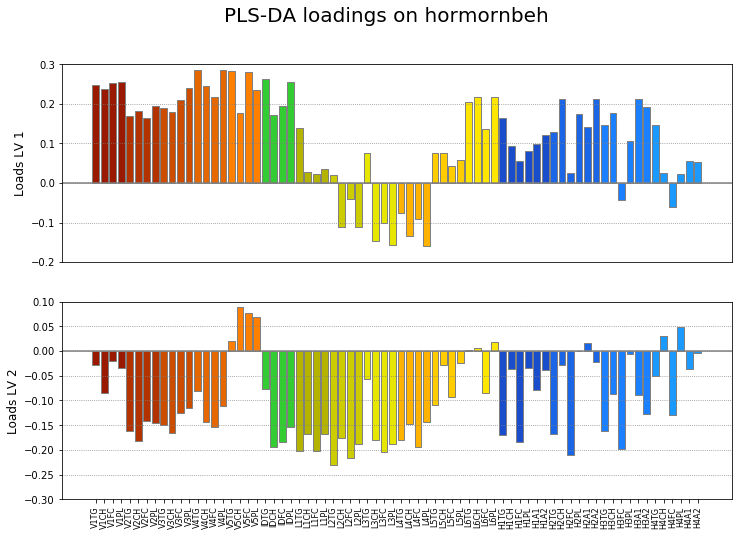

In [1409]:
# --- 3 --- Final PLS model --------------------------------------------------

# X_scores, Y_scores, X_loads, Y_loads = PLS_fit_model( ZZ, YY.loc[:, Response_Col], 5, Response_Col)

X_loads = X_loads_ortho

# --- 5 --- Plot LV LOADING separatly in histograms --------------------------

# Create a table with all that we need for plotting the desired results 
DF_scores = X_loads.copy() 
plotDF = DF_scores.iloc[:,[0,1]]

# Set the variables names and colors based on the data_type used for the model
if   data_type == "LP":
    vars_LP_order = [  
                    'V1TG', 'V1CH', 'V1FC', 'V1PL', 
                    'V2TG', 'V2CH', 'V2FC', 'V2PL', 
                    'V3TG', 'V3CH', 'V3FC', 'V3PL', 
                    'V4TG', 'V4CH', 'V4FC', 'V4PL', 
                    'V5TG', 'V5CH', 'V5FC', 'V5PL', 

                    'IDTG', 'IDCH', 'IDFC', 'IDPL',

                    'L1TG', 'L1CH', 'L1FC', 'L1PL',
                    'L2TG', 'L2CH', 'L2FC', 'L2PL',
                    'L3TG', 'L3CH', 'L3FC', 'L3PL',
                    'L4TG', 'L4CH', 'L4FC', 'L4PL',
                    'L5TG', 'L5CH', 'L5FC', 'L5PL',
                    'L6TG', 'L6CH', 'L6FC', 'L6PL',

                    'H1TG', 'H1CH', 'H1FC', 'H1PL', 'H1A1', 'H1A2',
                    'H2TG', 'H2CH', 'H2FC', 'H2PL', 'H2A1', 'H2A2',
                    'H3TG', 'H3CH', 'H3FC', 'H3PL', 'H3A1', 'H3A2',
                    'H4TG', 'H4CH', 'H4FC', 'H4PL', 'H4A1', 'H4A2',
                    ]

    # Create a concatenated list of RGB values to assign vars_MB_order colors 
    # NOTE 1 : use * operator for list concatenation and *n for repeation
    # NOTE 2 : the indexes of the DF (variables) )were reorganized before based on vars_LP_order list
    vars_color = [*[[.6,.1,.0]]*4 , *[[.7,.2,.0]]*4 , *[[.8,.3,.0]]*4 , *[[.9,.4,.0]]*4, *[[1 ,.5,.0]]*4,
                  *[[.2,.8,.2]]*4 , 
                  *[[.7,.7,.0]]*4 , *[[.8,.8,.0]]*4 , *[[.9,.9,.0]]*4 , 
                  *[[1.,.7,.0]]*4 , *[[1.,.8,.0]]*4 , *[[1.,.9,.0]]*4 ,
                  *[[.1,.3,.8]]*6 , *[[.1,.4,.9]]*6 , *[[.1,.5,1.]]*6 , *[[.1,.6,1.]]*6,
    ]   
    
    
elif data_type == "MB":    
    vars_MB_order = [ 'Lysine', 'Histidine', 'Glutamic acid',
                      'Glutamine', 'Asparagine', 'Threonine', 
                      'Glycine', 'Proline',
                      'Phenylalanine', 'Leucine', 'Alanine', 'Tyrosine', 'Valine', 'Isoleucine', 'Methionine',                  
                      'N,N-Dimethylglycine', 'Ornithine', 'Sarcosine',                 
                      '2-Hydroxybutyric acid', '3-Hydroxybutyric acid', '2-Oxoglutaric acid', '2-Aminobutyric acid',
                      'Pyruvic acid', 'Citric acid', 'Acetic acid', 'Lactic acid', 'Succinic acid', 'Formic acid', 'Acetoacetic acid',                  
                      'K-EDTA','Ca-EDTA',                 
                      'Acetone', 'Glycerol',                 
                      'D-Galactose', 'Glucose',                 
                      'Dimethylsulfone',                   
                      'Choline', 'Creatine', 'Creatinine'
                     ]
    # Create a concatenated list of RGB values to assign vars_MB_order colors 
    # NOTE 1 : use * operator for list concatenation and *n for repeation
    # NOTE 2 : the indexes of the DF (variables) )were reorganized before based on vars_MB_order list
    vars_color = [*[[0,0.6,1]]*3 , *[[0, 0.4, 1]]*3 , *[[0, 0.2, 1]]*2 , *[[0, 0, 1]]*7,
                  *[[1,0.8,0.2]]*3 , 
                  *[[1,0.4,0.2]]*4 , 
                  *[[1,0.0,0.2]]*7 , 
                  *[[0.2, 0.5, 0.2]]*2 , *[[0.1, 0.6, 0.1]]*2 , *[[0.0, 0.6, 0.0]]*2 , *[[.8, .8, 0]]*1, *[[0, 0.7, 0.2]]*3 ] 

    # reorganize the indexes of the DF based on vars_MB_order list 
    plotDF = plotDF.reindex(vars_MB_order)
    
    
x_pos = range(plotDF.shape[0])

# Plot the loading scores individually as barplots 
# We can also color each category of variables with a unique color
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
fig.suptitle('PLS-DA loadings on '+ Response_Col , fontsize = 20)

# --- SubPlot 1
ax1.bar(x_pos,  plotDF.loc[:, plotDF.columns[0]] ,  align='center',
          color=vars_color,  edgecolor='grey')
ax1.grid(axis="y", color = "grey", linestyle='dotted')
ax1.axhline(y=0, linestyle='-', color='grey')
ax1.set_ylabel('Loads LV 1', fontsize = 12)
ax1.set_xticks([])
ax1.set_xticklabels([])

# --- SubPlot 2
ax2.bar(x_pos,  plotDF.loc[:, plotDF.columns[1]] ,  align='center',
         color=vars_color,  edgecolor='grey')
ax2.grid(axis="y", color = "grey", linestyle='dotted')
ax2.axhline(y=0, linestyle='-', color='grey')
ax2.set_ylabel('Loads LV 2', fontsize = 12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(vars_LP_order, rotation = 90, fontsize=8)


# Choose plot axis limit based on max plotted value +15% margin
ngLim = round(np.min(plotDF.iloc[:,0].values)  * 1.10, 1)
psLim = round(np.max(plotDF.iloc[:,0].values)  * 1.10, 1)
ax1.set_ylim([ngLim, psLim])

ngLim = round(np.min(plotDF.iloc[:,1].values)  * 1.10, 1)
psLim = round(np.max(plotDF.iloc[:,1].values)  * 1.10, 1)
ax2.set_ylim([ngLim, psLim])

# --- SAVE the plot ----------------------------------------------------------

In [1414]:
ZZ_pls.x_scores

AttributeError: 'PLSRegression' object has no attribute 'x_scores'

In [1499]:
X_scores_oPLS1

,Score_X_LV_1,Score_X_LV_2,Score_X_LV_3,Score_X_LV_4,Score_X_LV_5,Score_X_LV_6
0,0.110513,0.893954,-0.017981,-3.475105,0.578967,0.349965
1,-1.605365,6.290061,-0.689969,0.052773,0.057744,-1.549132
2,3.034233,6.431464,2.998476,1.532492,-0.952362,-1.172603
3,-2.243980,-1.121802,0.523711,-0.701100,2.613026,0.707881
4,1.553532,3.961602,1.012053,-0.899511,0.670535,-0.405169
...,...,...,...,...,...,...
142,-1.710695,-0.547930,-0.822192,-0.383491,-0.010633,-0.018380
143,-2.914386,-3.226948,0.027668,-0.860525,0.550165,-0.260144
144,2.018817,3.096884,-1.878087,1.033908,1.484743,0.166562
145,-1.386832,-2.090864,0.831120,-1.805513,0.241740,0.104228


In [1500]:
X_scores_oPLS2

,Score_X_LV_1,Score_X_LV_2,Score_X_LV_3,Score_X_LV_4,Score_X_LV_5,Score_X_LV_6
0,-0.019678,-3.475105,0.578967,0.349965,-0.834182,-0.243808
1,-2.718078,0.052773,0.057744,-1.549132,-0.741343,0.144051
2,5.140445,1.532492,-0.952362,-1.172603,-0.984614,-0.502804
3,-1.155578,-0.701100,2.613026,0.707881,0.025930,-1.034701
4,1.988549,-0.899511,0.670535,-0.405169,0.280560,0.518965
...,...,...,...,...,...,...
142,-2.255669,-0.383491,-0.010633,-0.018380,-0.568977,0.037419
143,-2.038768,-0.860525,0.550165,-0.260144,-0.881092,-0.115627
144,-0.719924,1.033908,1.484743,0.166562,0.984111,-0.432496
145,-0.014069,-1.805513,0.241740,0.104228,-0.635828,-0.484133


In [1501]:
X_scores_oPLS3

,Score_X_LV_1,Score_X_LV_2,Score_X_LV_3,Score_X_LV_4,Score_X_LV_5,Score_X_LV_6
0,1.119236,0.349965,-0.834182,-0.243808,0.539697,-0.113210
1,-2.421572,-1.549132,-0.741343,0.144051,-0.502150,0.118549
2,3.674860,-1.172603,-0.984614,-0.502804,1.009131,1.087485
3,0.809219,0.707881,0.025930,-1.034701,-1.387701,-0.889632
4,2.422873,-0.405169,0.280560,0.518965,0.678354,0.015585
...,...,...,...,...,...,...
142,-1.954029,-0.018380,-0.568977,0.037419,0.168896,0.003780
143,-1.290206,-0.260144,-0.881092,-0.115627,0.648576,-0.322943
144,0.089091,0.166562,0.984111,-0.432496,-0.585301,-0.707721
145,0.539702,0.104228,-0.635828,-0.484133,-1.743226,-0.125938
